In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import math


$\alpha_t$ controls how much noise we add at timestep $t$.

$\beta_t$ controls the variance of the noise added at timestep $t$.

1) $\alpha_t = 1 - \beta_t$ the noise strength changes at each timestep $t$ (depends on $\beta_t$)
2) $\bar{\alpha_t} = \prod_{s=1}^{t} a_s$

Equations (1) and (2) is from the paper "Denoising Diffusion Probabilistic Models"

3) $x_t = \sqrt{\bar{\alpha_t}} x_0 + \sqrt{1 - \bar{\alpha_t}} \epsilon$ - the forward diffusion process $q(x_t | x_0)$

Equation (3): instead of iteratively adding noise, we do it in one single step (from $x_0$ we get to $x_t$). The $\epsilon$ is random Gaussian noise.

In [2]:
"""
beta_start and beta_end are hyperparameters
"""
class LinearNoiseScheduler:
    def __init__(self, timesteps: int = 1000, beta_start: float = 1e-4, beta_end: float = 0.02):
        self.timesteps = timesteps

        # Start and end are the beta values for the linear noise schedule that we linearly interpolate between (hence linear scheduler)
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas # Equation 1
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)  # Equation 2

    def add_noise(self, x0: torch.Tensor, t: torch.Tensor):
        """
        Forward process: q(x_t | x_0)
        """
        epsilon = torch.randn_like(x0) # Input: x_0 - it returns the same size/shape as the input tensor (i.e. image)

        # gather alpha_bars for each sample in the batch
        alpha_bar_t = self.alpha_hat[t].view(-1, 1, 1, 1).to(x0.device)
        first_term = torch.sqrt(alpha_bar_t) * x0
        second_term = torch.sqrt(1 - alpha_bar_t) * epsilon
        return first_term + second_term # Equation 3

Load CIFAR-10 dataset

In [3]:
transform = T.Compose([
    T.ToTensor(),  # converts to [0, 1]
    T.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])
dataset = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
img, label = dataset[0]  # get a single image
x0 = img.unsqueeze(0)  # add batch dimension

100%|██████████| 170M/170M [00:09<00:00, 17.2MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data


Apply noise scheduler

In [4]:
def plot(timesteps, beta_start, beta_end, plotted_timesteps):
    scheduler = LinearNoiseScheduler(timesteps=timesteps, beta_start=beta_start, beta_end=beta_end)
    noisy_images = []

    for t in plotted_timesteps:
        timestep = torch.tensor([t])
        noisy_img = scheduler.add_noise(x0, timestep)
        noisy_images.append(noisy_img)

    num_images = len(plotted_timesteps)
    cols = 4
    rows = math.ceil(num_images / cols)

    def show_image(tensor, title=""):
        img = tensor.clone().detach().cpu()
        img = img * 0.5 + 0.5  # unnormalize
        img = img.clamp(0, 1)  # clip to [0, 1] to avoid warnings
        img = img.squeeze().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.figure(figsize=(12, 5))  # slightly smaller figure
    for i, (t, img) in enumerate(zip(plotted_timesteps, noisy_images)):
        plt.subplot(rows, cols, i + 1)
        show_image(img, f"t={t}")

    plt.suptitle(f"Diffusion Noise Over Time (beta_start = {beta_start}, beta_end = {beta_end})", fontsize=14)
    plt.tight_layout(pad=1.0)  # reduce padding between subplots
    plt.subplots_adjust(wspace=0.01, hspace=0.3)  # tighter spacing
    plt.show()

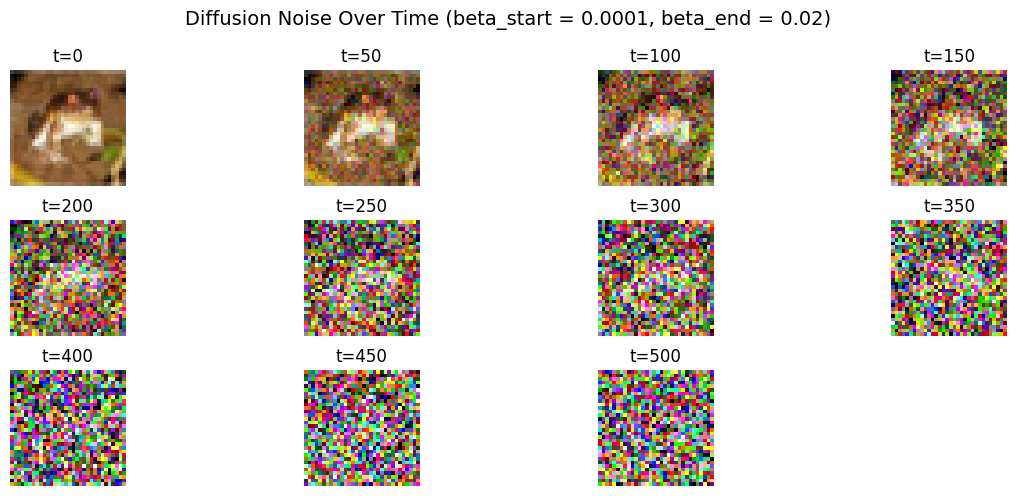

In [5]:
plotted_timesteps = list(range(0, 501, 50))  # [0, 50, 100, ..., 500]
plot(timesteps=1000, beta_start=1e-4, beta_end=0.02, plotted_timesteps=plotted_timesteps)

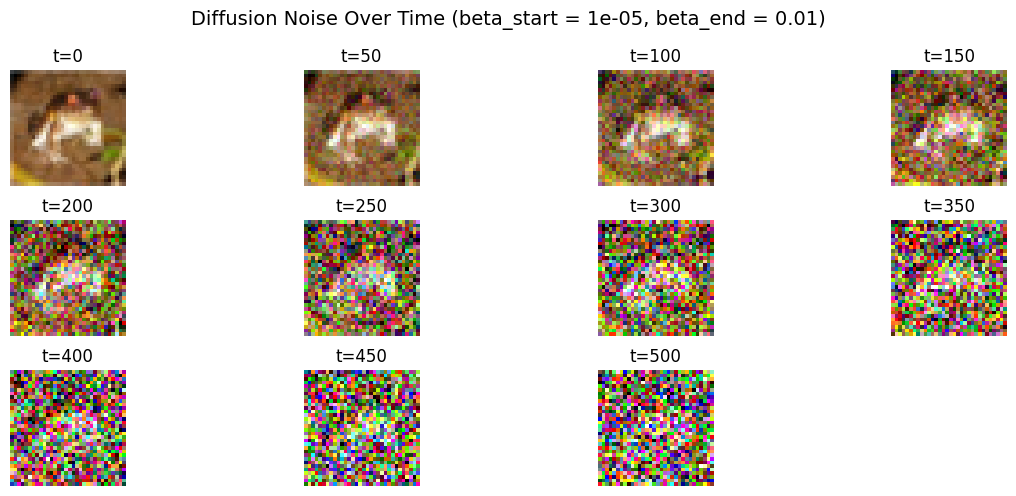

In [6]:
plotted_timesteps = list(range(0, 501, 50))  # [0, 50, 100, ..., 500]
plot(timesteps=1000, beta_start=1e-5, beta_end=0.01, plotted_timesteps=plotted_timesteps)